Image chargée avec succès !
Dimensions de l'image : (1024, 1280)
Type de données : uint16


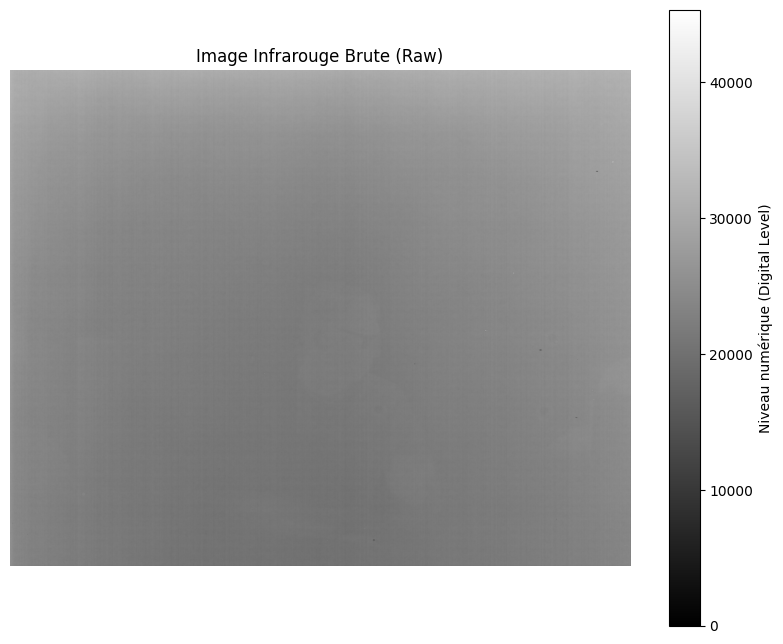

Valeur min : 0
Valeur max : 45332
Moyenne   : 24038.26


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Définition du chemin du fichier
# Note : On utilise r"..." pour que Python gère correctement les antislashes Windows
file_path = r"C:\Users\prich\Documents\Lynred\im_ir\im_ir_00000001.tif"

# 2. Chargement de l'image
# IMPORTANT : Le flag 'cv2.IMREAD_UNCHANGED' ou -1 est crucial.
# Sans lui, OpenCV risque de convertir l'image brute 16 bits en 8 bits, 
# ce qui écraserait la dynamique nécessaire pour la NUC et le BPR.
img_raw = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

# 3. Vérification du chargement
if img_raw is None:
    print(f"Erreur : Impossible de charger l'image à l'emplacement : {file_path}")
    print("Vérifiez que le chemin est correct et que le fichier existe.")
else:
    print("Image chargée avec succès !")
    print(f"Dimensions de l'image : {img_raw.shape}")
    print(f"Type de données : {img_raw.dtype}") 
    # Vous devriez voir 'uint16' ici, confirmant que c'est bien l'image brute.

    # 4. Affichage simple (Visualisation brute)
    # Les images brutes sont souvent très sombres ou peu contrastées avant traitement.
    # Matplotlib gère automatiquement le min/max pour l'affichage, ce qui aide à voir quelque chose.
    plt.figure(figsize=(10, 8))
    plt.imshow(img_raw, cmap='gray')
    plt.title("Image Infrarouge Brute (Raw)")
    plt.colorbar(label="Niveau numérique (Digital Level)")
    plt.axis('off') # Enlever les axes pour plus de clarté
    plt.show()

    # Statistiques simples pour comprendre la dynamique du capteur
    print(f"Valeur min : {np.min(img_raw)}")
    print(f"Valeur max : {np.max(img_raw)}")
    print(f"Moyenne   : {np.mean(img_raw):.2f}")

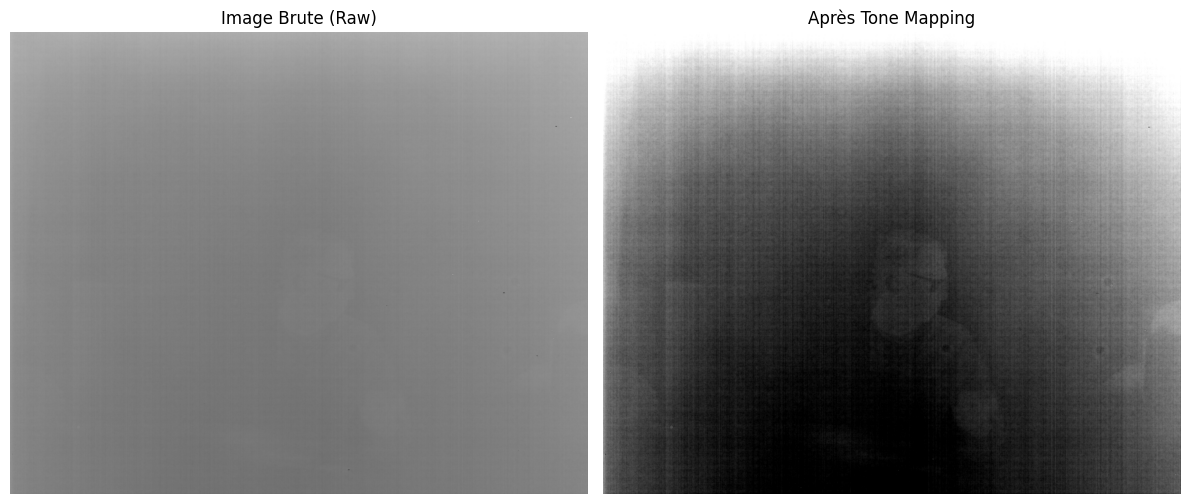

In [19]:
def tone_mapping(img_raw, percentile_low=5, percentile_high=95):
    """
    Applique un tone mapping linéaire simple.
    
    Paramètres:
    -----------
    img_raw : ndarray
        Image brute en uint16
    percentile_low : float
        Percentile inférieur pour le clipping (0-100)
    percentile_high : float
        Percentile supérieur pour le clipping (0-100)
    
    Retourne:
    ---------
    img_mapped : ndarray
        Image mappée en uint8 (0-255)
    """
    # Clipping sur les percentiles
    vmin = np.percentile(img_raw, percentile_low)
    vmax = np.percentile(img_raw, percentile_high)
    img_clipped = np.clip(img_raw, vmin, vmax)
    
    # Normalisation et conversion en uint8
    img_output = ((img_clipped - vmin) / (vmax - vmin) * 255).astype(np.uint8)
    
    return img_output


# Utilisation
if img_raw is not None:
    img_tone = tone_mapping(img_raw)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].imshow(img_raw, cmap='gray')
    axes[0].set_title('Image Brute (Raw)')
    axes[0].axis('off')
    
    axes[1].imshow(img_tone, cmap='gray')
    axes[1].set_title('Après Tone Mapping')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, "Image après Correction d'Offset et tone mapping")

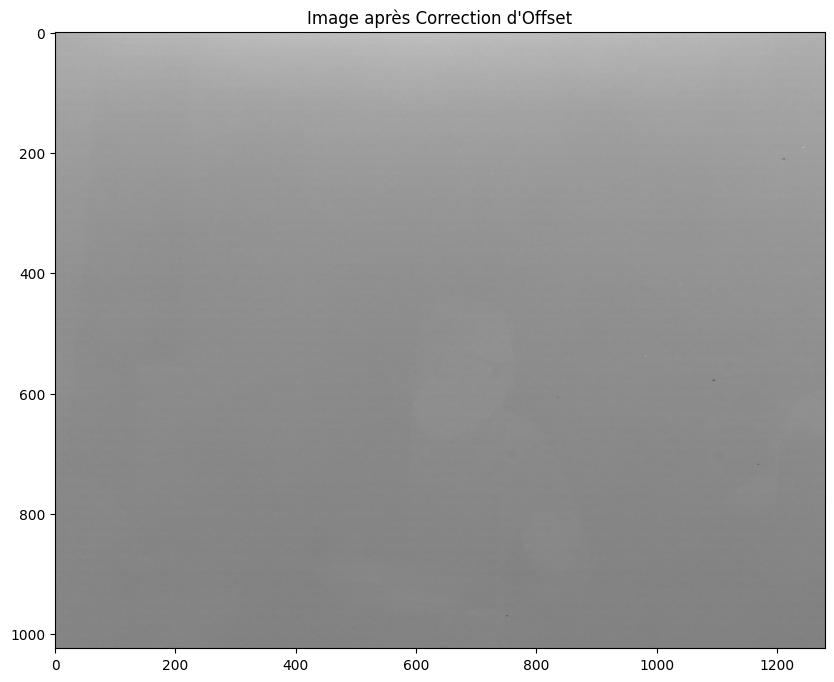

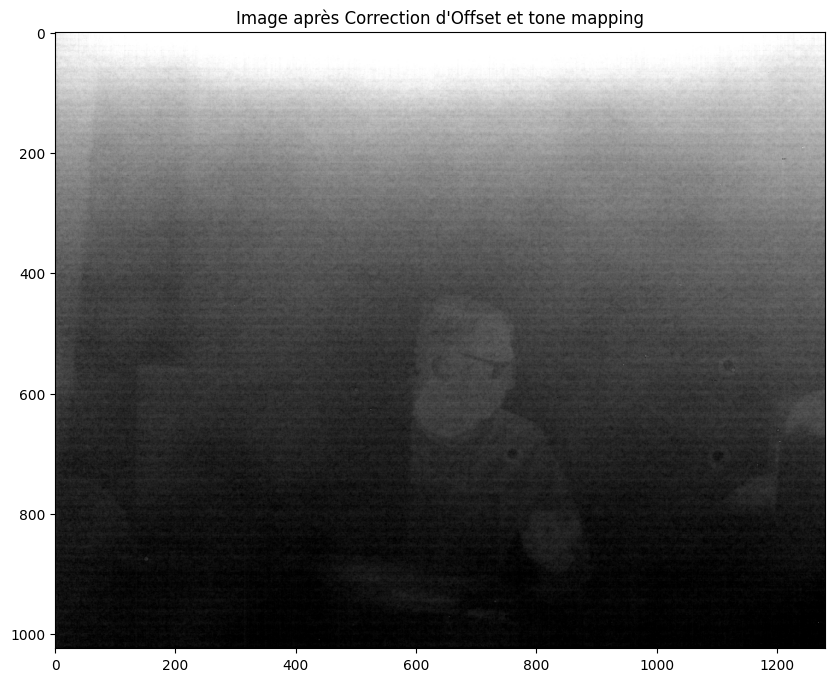

In [31]:
#Traitement NUC avec correction d'offset

offset = cv2.imread(r"C:\Users\prich\Documents\Lynred\bb1\im_ir_bb1_00000001.tif", cv2.IMREAD_UNCHANGED)

def compute_offset_map(ref_images):
    """
    Calcule la carte d'offset à partir d'une série d'images de référence (corps noir).
    
    Args:
        ref_images (list ou np.array): Liste d'images (2D) ou tableau 3D (N, H, W)
                                       d'une scène uniforme.
    
    Returns:
        offset_map (np.array): La matrice des offsets à soustraire (type float64).
    """
    # 1. Moyennage temporel pour réduire le bruit (recommandé slide 30)
    # On transforme la liste en tableau numpy si nécessaire
    stack = np.array(ref_images, dtype=np.float64)
    
    # Moyenne pixel par pixel sur l'axe temporel (axis 0)
    # Images_T1 dans la formule
    avg_ref_img = np.mean(stack, axis=0)
    
    # 2. Calcul de la moyenne spatiale de l'image de référence
    # <Images_T1> dans la formule
    global_mean = np.mean(avg_ref_img)
    
    # 3. Calcul de la carte d'offset
    # Formule : Offset = Images_T1 - <Images_T1>
    offset_map = avg_ref_img - global_mean
    
    return offset_map

def apply_offset_correction(raw_img, offset_map):
    """
    Applique la correction d'offset sur une image brute.
    
    Args:
        raw_img (np.array): Image brute (uint14/16).
        offset_map (np.array): Carte d'offset calculée précédemment.
        
    Returns:
        corrected_img (np.array): Image corrigée (float64).
    """
    # Conversion en float pour éviter les erreurs de signe (underflow)
    img_float = raw_img.astype(np.float64)
    
    # Application de la formule : pixel_corrige = pixel_brut - offset
    corrected_img = img_float - offset_map
    
    return corrected_img


offset_map = compute_offset_map(offset)
corrected_img = apply_offset_correction(img_raw, offset_map)
# Affichage de l'image corrigée
plt.figure(figsize=(10, 8))
plt.imshow(corrected_img, cmap='gray')
plt.title("Image après Correction d'Offset")

img_tone_offset = tone_mapping(corrected_img)
plt.figure(figsize=(10, 8))
plt.imshow(img_tone_offset, cmap='gray')
plt.title("Image après Correction d'Offset et tone mapping")

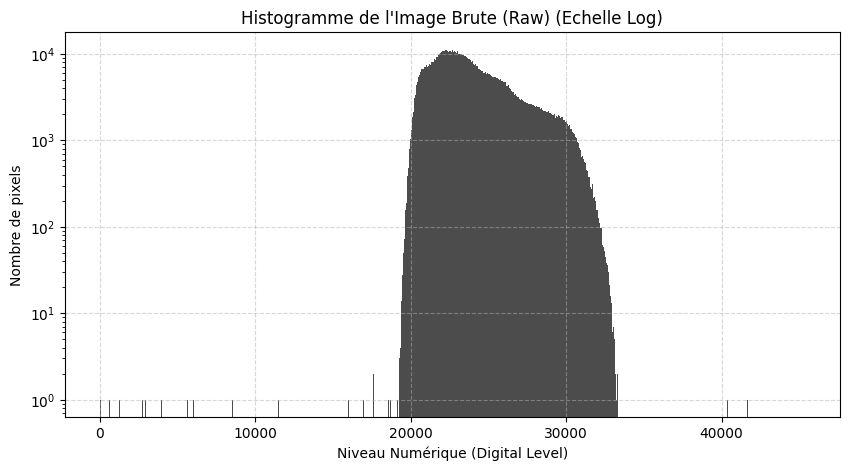

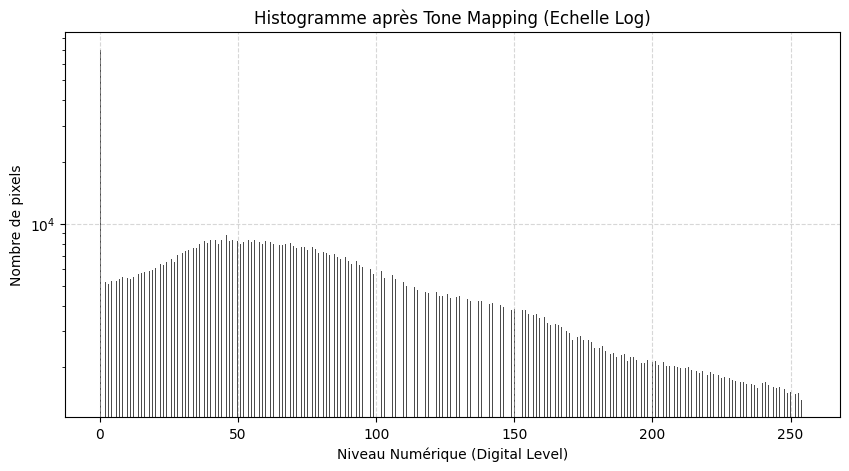

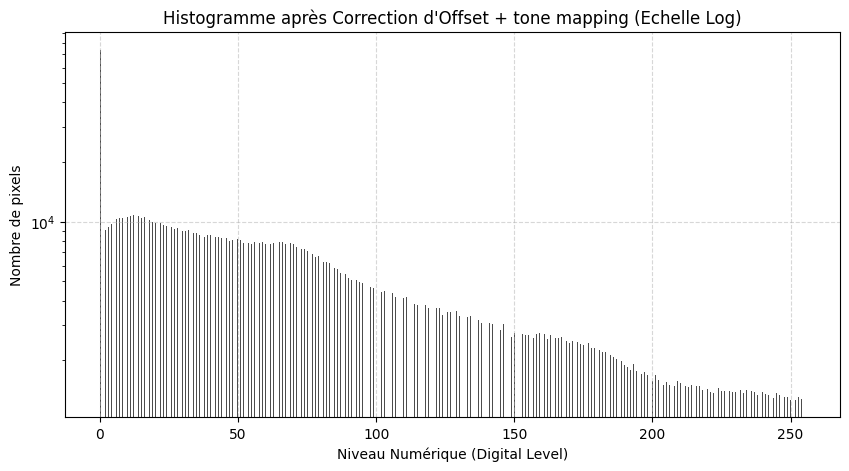

In [32]:
def plot_histogram(image, title="Histogramme", bins=1024, log_scale=False):
    """
    Affiche l'histogramme des niveaux de gris d'une image.
    
    Args:
        image (np.array): L'image (2D) dont on veut l'histogramme.
        title (str): Titre du graphique.
        bins (int): Nombre de barres dans l'histogramme. 
                    Pour du 16 bits, mettez une valeur élevée (ex: 1024 ou 'auto').
        log_scale (bool): Si True, passe l'axe Y en échelle logarithmique 
                          (utile pour voir les pixels rares comme les pixels défectueux).
    """
    # 1. Aplatir l'image en 1D (transforme la matrice en une longue liste de pixels)
    data = image.ravel()
    
    plt.figure(figsize=(10, 5))
    
    # 2. Création de l'histogramme
    # color='black' rappelle qu'on travaille en niveaux de gris
    # alpha=0.7 permet de voir la grille derrière
    plt.hist(data, bins=bins, color='black', alpha=0.7)
    
    # 3. Configuration de l'échelle logarithmique (optionnel mais recommandé en IR)
    if log_scale:
        plt.yscale('log')
        title += " (Echelle Log)"
    
    plt.title(title)
    plt.xlabel("Niveau Numérique (Digital Level)")
    plt.ylabel("Nombre de pixels")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Affichage des histogrammes
plot_histogram(img_raw, title="Histogramme de l'Image Brute (Raw)",log_scale=True)
plot_histogram(img_tone, title="Histogramme après Tone Mapping", log_scale=True)
plot_histogram(img_tone_offset, title="Histogramme après Correction d'Offset + tone mapping", log_scale=True)

Text(0.5, 1.0, "Image après Correction d'Offset, tone mapping et gain")

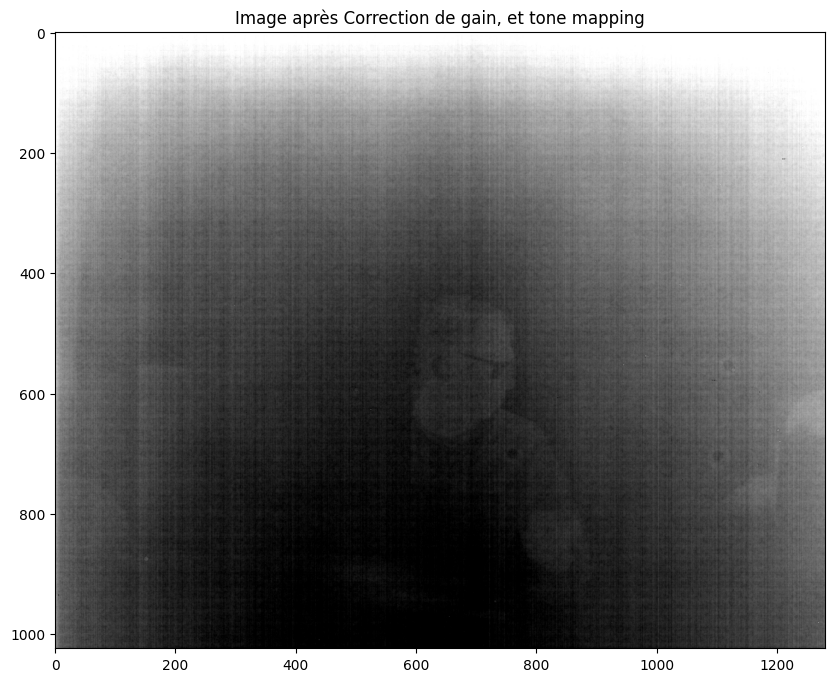

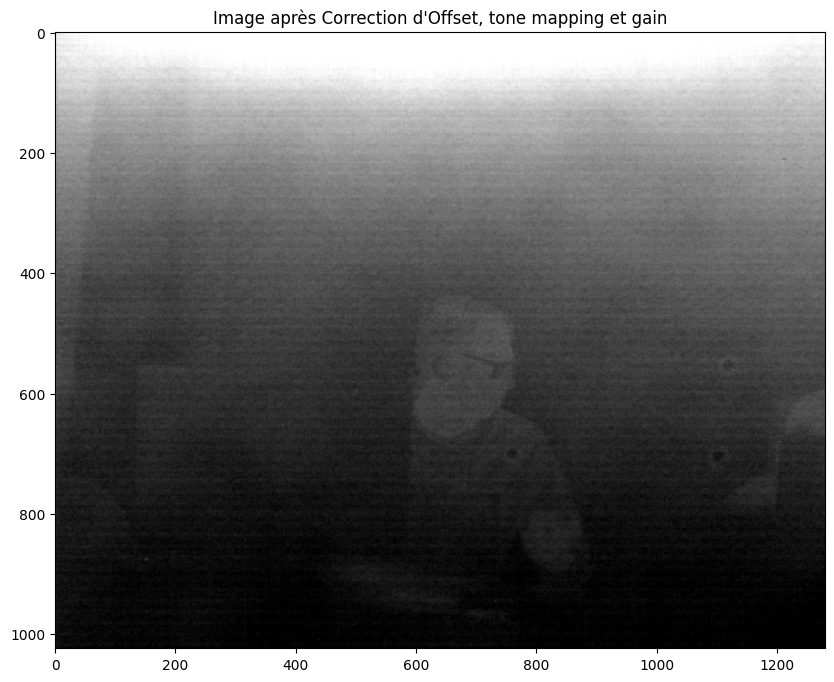

In [40]:
def compute_gain_map(ref_images, offset_map, img_raw):
    """
    Calcule la carte de gain pour la correction NUC 2 points.
    Basé sur la formule du cours : Gain = Moyenne(Ref_T2) / (Ref_T2 - Offset)
    
    Args:
        ref_images_hot (list ou np.array): Images de référence à haute température (T2).
        offset_map (np.array): Carte d'offset calculée précédemment (à T1).
        
    Returns:
        gain_map (np.array): La matrice des gains (multiplicateur).
    """
    # 1. Moyennage temporel des images chaudes pour réduire le bruit
    stack_hot = np.array(ref_images, dtype=np.float64)
    avg_ref_hot = np.mean(stack_hot, axis=0)
    
    # 2. Application de la correction d'offset sur la référence chaude
    # Cela correspond au dénominateur : (Images_T2 - Offset)
    # On regarde comment l'image chaude réagirait avec juste l'offset.
    img_hot_offset_corrected = avg_ref_hot - offset_map
    
    # 3. Calcul de la moyenne cible
    # On veut que tous les pixels atteignent cette valeur moyenne.
    target_mean = np.mean(avg_ref_hot)
    
    # 4. Calcul de la carte de gain
    # Si un pixel est "mou" (valeur < moyenne), le gain sera > 1 pour le booster.
    # On ajoute une petite valeur (epsilon) pour éviter la division par zéro, par sécurité.
    epsilon = 1e-6
    gain_map = target_mean / (img_hot_offset_corrected + epsilon)
    
    corrected_img = img_raw * gain_map
    return corrected_img

img_gain = compute_gain_map(offset, offset_map, img_raw)
img_gain = tone_mapping(img_gain)
plt.figure(figsize=(10, 8))
plt.imshow(img_gain, cmap='gray')
plt.title("Image après Correction de gain, et tone mapping")

image_offset = apply_offset_correction(img_raw, offset_map)
img_gain_offset = compute_gain_map(offset, offset_map, image_offset)
img_gain_offset = tone_mapping(img_gain_offset)
plt.figure(figsize=(10, 8))
plt.imshow(img_gain_offset, cmap='gray')
plt.title("Image après Correction d'Offset, tone mapping et gain")
 